#**Predict Energy Star Score using NYC Benchmarking Data**


## Import the libraries

In [118]:
#Import Data Set and Python Libraries
import math, time, random, datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
import seaborn as sns

plt.rcParams['font.size'] = 10

# Data Prep
from IPython.core.display import display_pdf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, Normalizer, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer

# Model Training
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,StackingRegressor,VotingRegressor
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance


#Model Evaluation
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV , KFold , StratifiedKFold

# Warning Control
import warnings
warnings.filterwarnings('ignore')


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the dataset

In [108]:
path = "drive/My Drive/Colab Notebooks/data/energy/"
df = pd.read_excel(path+"NYC_2020_Data_Updated.xlsx")

In [109]:
df.head(2)

,Property Id,Property Name,Address 1,City,Postcode,All Property Use,Primary Use,Primary Sqft,2nd Use,2nd Sqft,...,Community Board,Council District,Census Tract,NTA,Longitude,Latitude,BIN,Borough.1,Block,Lot
0,6404534,2238 Morris Avenue,2238 Morris Avenue,Bronx,10453,"Convenience Store without Gas Station, Multifa...",Multifamily Housing,26840.0,Convenience Store without Gas Station,500.0,...,205.0,14.0,23704.0,Fordham South,-73.902562,40.857059,2013860,2.0,3171.0,1.0
1,6575098,969 43rd Street,969 43 St,Brooklyn,11219,"Multifamily Housing, Personal Services (Health...",Multifamily Housing,39500.0,Supermarket/Grocery Store,5000.0,...,312.0,38.0,112.0,Sunset Park East,-73.996025,40.642867,3135794,3.0,5595.0,43.0


In [110]:

#replace "Not Available" with nothing
df = df.replace("Not Available",np.nan)

In [111]:
# Iterate through the columns
for col in list(df.columns):
    # Select columns that should be numeric
    if ('ft²' in col or 'Sqft' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in 
        col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        df[col] = df[col].astype(float)

##Missing Data

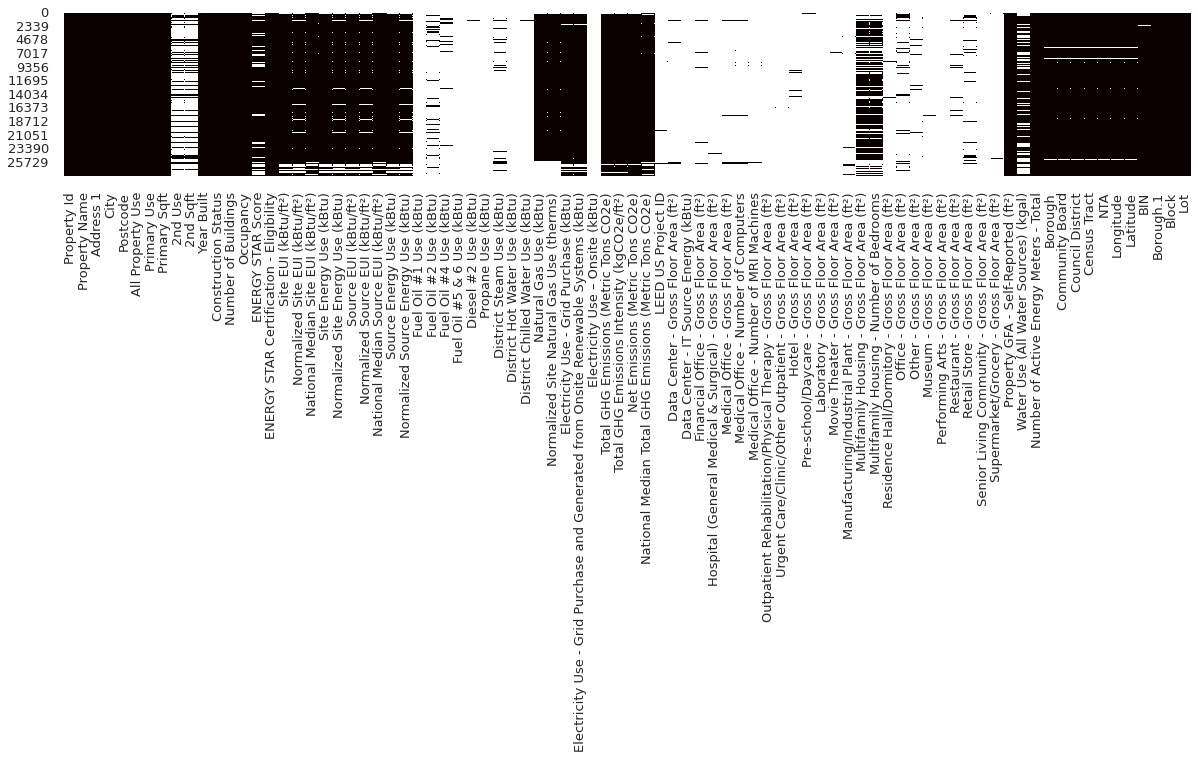

In [120]:
#@title
plt.figure(figsize=(18,3))
sns.heatmap(df.isnull(), cbar=False, cmap = "hot")

In [121]:
#shows the total number of missing values
df.isnull().sum().sum()

1040648

In [123]:
#variables which we can remove
var_null_pc = df.isnull().sum(axis=0).sort_values( ascending=False)/float(len(df) )

In [ ]:
df.drop( var_null_pc[ var_null_pc > 0.75 ].index, axis = 1,  ) 
df.dropna( axis = 0, thresh = 30, )

In [125]:
df.shape

(28067, 84)

In [126]:
# function to calculate missing values by column
def missing_values_table(df):
    #total mising values
    mis_val=df.isnull().sum()
    #% of missing values
    mis_val_percent=100*df.isnull().sum()/len(df)
    #make a table with results
    mis_val_table=pd.concat([mis_val,mis_val_percent],axis=1)
    #rename columns
    mis_val_table_ren_columns=mis_val_table.rename(columns={0:'missing values',1:'% of total values'})
    #sort the table by % of missing descending
    mis_val_table_ren_columns=mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of total values',ascending=False).round(1)
    #print some summery
    print('your data has ' + str(df.shape[1]) + " columns."
         'there are ' + str(mis_val_table_ren_columns.shape[0]) + ' columns with missing values')
    return mis_val_table_ren_columns

In [127]:
#get missing values > 50% missing
missing_df = missing_values_table(df);
missing_columns=list(missing_df[missing_df['% of total values'] > 50].index)

print(' Delete %d Variable.' %len(missing_columns))

your data has 84 columns.there are 72 columns with missing values
 Delete 36 Variable.


In [128]:
#drop columns
df=df.drop(columns=list(missing_columns))

In [129]:
df.dropna(inplace=True)

In [130]:
nulls = df.isnull().sum()
nulls[nulls > 0]

Series([], dtype: int64)

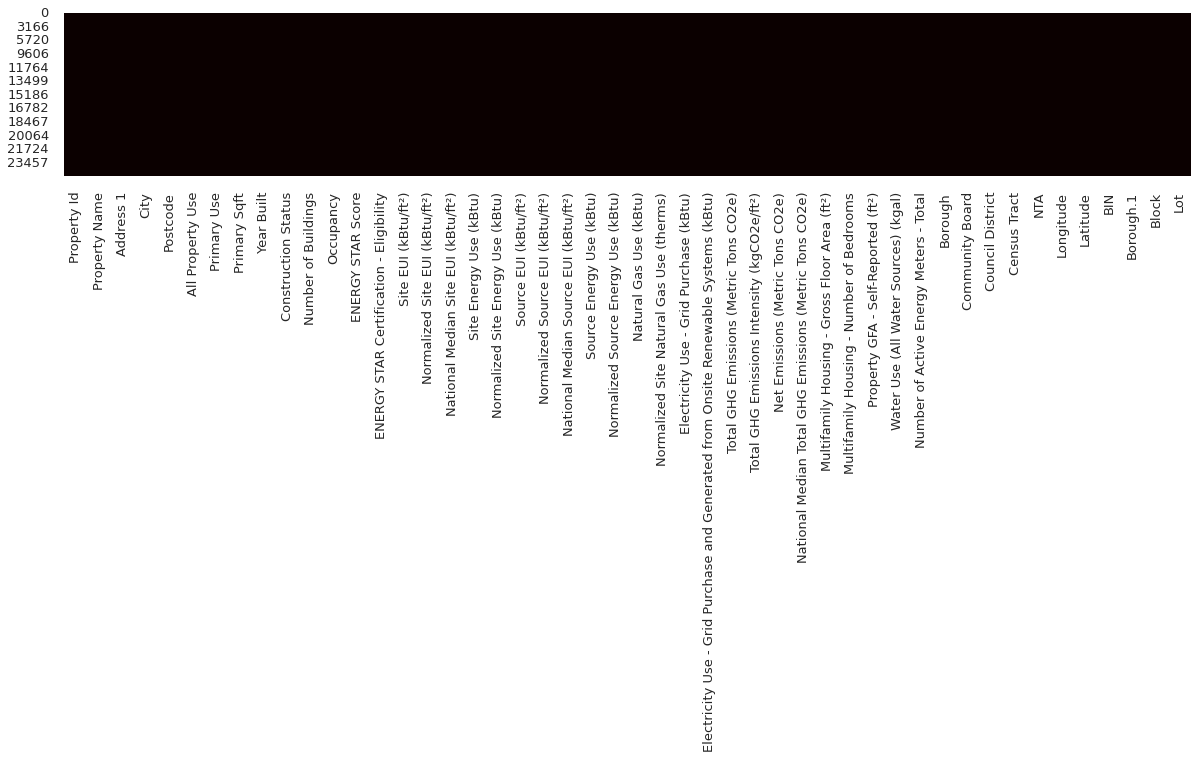

In [132]:
#@title
plt.figure(figsize=(18,3))
sns.heatmap(df.isnull(), cbar=False, cmap = "hot")

## One Hot Encoding

In [133]:
# find categorical variables
categorical = [var for var in df.columns if df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 11 categorical variables


In [134]:
df[categorical].columns

Index(['Property Name', 'Address 1', 'City', 'Postcode', 'All Property Use',
       'Primary Use', 'Construction Status',
       'ENERGY STAR Certification - Eligibility', 'Borough', 'NTA', 'BIN'],
      dtype='object')

In [135]:
cat=['Property Name', 'Address 1', 'City', 'Postcode', 'All Property Use',
       'Primary Use', 'Construction Status',
       'ENERGY STAR Certification - Eligibility', 'Borough', 'NTA', 'BIN']

In [136]:
le = LabelEncoder()
for var in cat:
    le = LabelEncoder()
    df[var]=le.fit_transform(df[var].astype('str'))

In [137]:
df.columns

Index(['Property Id', 'Property Name', 'Address 1', 'City', 'Postcode',
       'All Property Use', 'Primary Use', 'Primary Sqft', 'Year Built',
       'Construction Status', 'Number of Buildings', 'Occupancy',
       'ENERGY STAR Score', 'ENERGY STAR Certification - Eligibility',
       'Site EUI (kBtu/ft²)', 'Normalized Site EUI (kBtu/ft²)',
       'National Median Site EUI (kBtu/ft²)', 'Site Energy Use (kBtu)',
       'Normalized Site Energy Use (kBtu)', 'Source EUI (kBtu/ft²)',
       'Normalized Source EUI (kBtu/ft²)',
       'National Median Source EUI (kBtu/ft²)', 'Source Energy Use (kBtu)',
       'Normalized Source Energy Use (kBtu)', 'Natural Gas Use (kBtu)',
       'Normalized Site Natural Gas Use (therms)',
       'Electricity Use - Grid Purchase (kBtu)',
       'Electricity Use - Grid Purchase and Generated from Onsite Renewable Systems (kBtu)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Total GHG Emissions Intensity (kgCO2e/ft²)',
       'Net Emissions (Metri

##Target Distribution

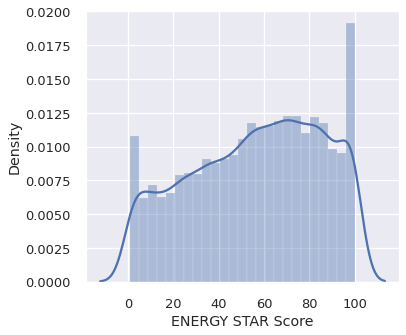

In [138]:
plt.figure(figsize=(5, 5))
sns.distplot(df['ENERGY STAR Score'])

##Split Train and Test Data

In [139]:
y=df['ENERGY STAR Score']
X=df.drop('ENERGY STAR Score',axis=1)

In [140]:
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Regression Model Assumptions

Transformation is required to treat the skewed features and make them normally distributed.

In [141]:
def normality_plot(X):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()


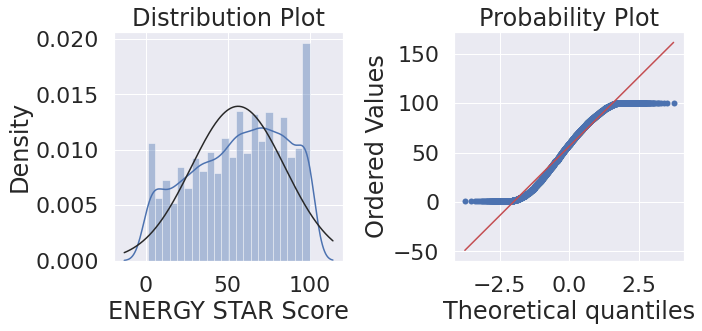

In [105]:
normality_plot(y_train)

##Machine Learning Algorithms

In [142]:
model_names = ['LinearRegression', 'Ridge', 'Lasso', 'RandomForestRegressor', 'BaggingRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor', 'XGBRegressor']  

In [76]:
regressions = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    RandomForestRegressor(n_estimators=100),
    BaggingRegressor(n_estimators=100),
    GradientBoostingRegressor(n_estimators=100,alpha=0.01),
    AdaBoostRegressor(n_estimators=100, random_state=0),
    XGBRegressor(n_estimators=100),]

Every model in Scikit-learn has a score method after being trained on X_train, y_train. Models have a score method providing a default evaluation criterion for the problem they are designed to solve. 

In [77]:
def predict_models(names, models, X_train, y_train):

    y_preds = []
    for name, model in zip(names, models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_train).tolist()
        y_preds.append(y_pred)
 
    pred_dict = dict(zip(names, y_preds))
    pred_dict = pd.DataFrame.from_dict(pred_dict)
    return pred_dict

In [78]:
pred_dict = predict_models(model_names, regressions, X_train, y_train)

[05:25:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [79]:
pred_dict.head()

,LinearRegression,Ridge,Lasso,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,96.933370,96.994662,94.464546,100.00,99.98,99.487296,93.362768,99.750168
1,58.038083,58.018022,59.187967,69.93,70.07,69.684663,67.814978,69.723015
2,90.443734,90.500960,87.725742,96.90,96.80,97.297895,87.065104,96.986649
3,57.371085,57.351050,56.037616,71.75,71.95,71.530814,63.056841,71.783051
4,49.933821,49.842425,51.602316,57.90,58.06,60.166712,60.529933,59.524479



##Evaluation

Root Mean Squared Error

RMSE is the square root of MSE which measures accuracy, to compare errors of different calculation models for the same dataset. It's also called the l-2 norm. Is the most popular norm, also known as the Euclidean norm. It is the shortest distance to go from one point to another.  

$$ RMSE = \sqrt{\sum_{i=1}^{N}(y_i-y_{i}^{pred})^2} $$

###Performance Metrics

In [83]:
def get_metrics_values(y_test, pred_dict, metric_name):

  models = pred_dict.columns.tolist()

  metrics_list = []
  for model in models:
    if metric_name == 'RMSE':
      metric = mean_squared_error(y_test, pred_dict[model], squared=False)
    elif metric_name == 'RMSLE':
      metric = mean_squared_log_error(y_test, pred_dict[model], squared=False)
    metrics_list.append(metric)
  
  metrics_dict = dict(zip(models, metrics_list))
  metrics_df = pd.DataFrame([metrics_dict])
  metrics_df['Evaluation'] = metric_name
  first_col = metrics_df.pop('Evaluation')
  metrics_df.insert(0, 'Evaluation', first_col)
  return metrics_df

#### RMSE (sklearn)

In [84]:
rmse = get_metrics_values(y_train, pred_dict, metric_name = 'RMSE')
rmse

,Evaluation,LinearRegression,Ridge,Lasso,RandomForestRegressor,BaggingRegressor,GradientBoostingRegressor,AdaBoostRegressor,XGBRegressor
0,RMSE,15.148792,15.14917,15.433399,0.575668,0.575323,1.65414,8.107033,1.748248


In [86]:
evaluation_rmse = pd.concat([rmse]).T

In [87]:
def get_evaluation_df(evaluation_df, metric_name):
  evaluation_df.columns = evaluation_df.iloc[0].values.tolist()
  evaluation_df['Model'] = evaluation_df.index
  first_col = evaluation_df.pop('Model')
  evaluation_df.insert(0, 'Model', first_col)
  evaluation_df.reset_index(inplace=True)
  evaluation_df.drop(evaluation_df.index[evaluation_df['Model'] == 'Evaluation'], inplace=True)
  evaluation_df.drop('index', axis=1, inplace=True)
  evaluation_df.sort_values(by=[metric_name], ascending=True, inplace=True)
  return evaluation_df

In [88]:
evaluation_rmse = get_evaluation_df(evaluation_rmse, metric_name = 'RMSE')

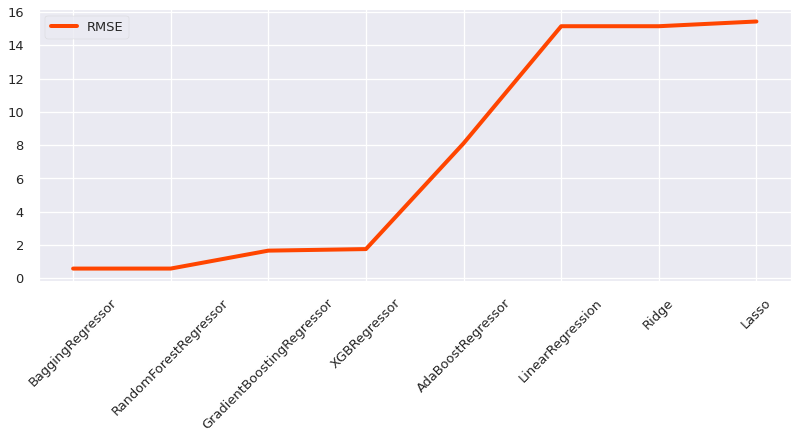

In [143]:
plt.figure(figsize=(12,5))
plt.plot(evaluation_rmse.Model,evaluation_rmse.RMSE, color='orangered', linewidth=4, label="RMSE")
plt.xticks(rotation = 45) # Rotates X-Axis 
plt.legend()
plt.show()

### Final Prediction

In [90]:
#@title
br = BaggingRegressor(n_estimators = 200, n_jobs = -1, random_state = 10)

In [91]:
#@title
best_predictor = br.fit(X_train, y_train)

In [92]:
#@title
train_predictions = best_predictor.predict(X_train)

In [93]:
#@title
test_predictions = best_predictor.predict(X_test)

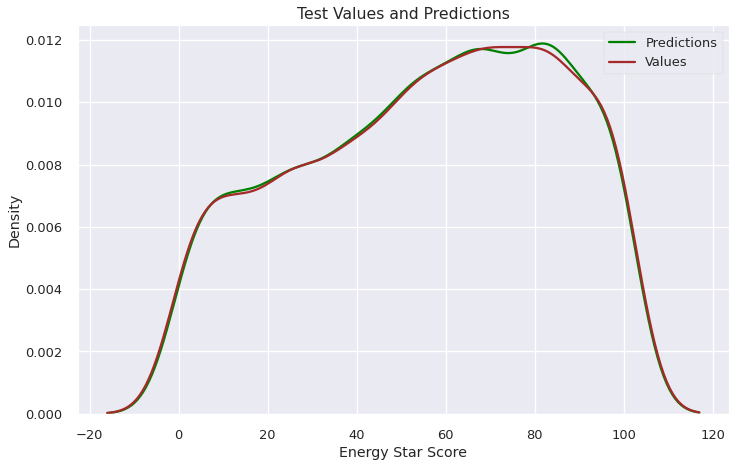

In [144]:
# Density plot of the final predictions and the test values
sns.kdeplot(test_predictions, label = 'Predictions',color='green')
sns.kdeplot(y_test, label = 'Values',color='brown')

# Label the plot
plt.xlabel('Energy Star Score'); plt.ylabel('Density');
plt.title('Test Values and Predictions');

plt.legend()

plt.show()